In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

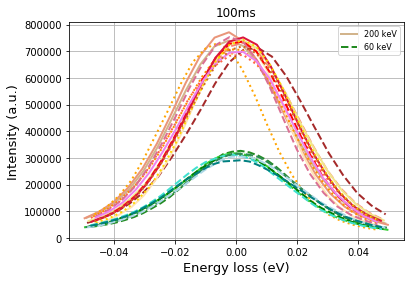

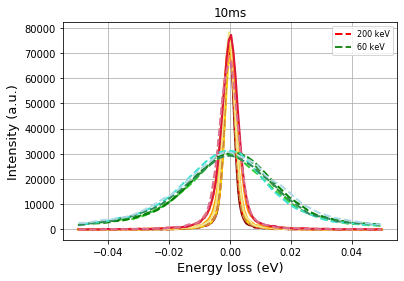

In [73]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py



### Find uncertainties on data

[24. 29. 22. 26. 23. 28. 31. 24. 24. 26. 20. 26. 25. 30. 27. 23. 26. 29.
 25. 21. 20. 29. 26. 24. 18. 22. 28. 30. 29. 20. 23. 24. 28. 22. 23. 28.
 28. 29. 21. 28. 20. 22. 27. 26. 27. 20. 22. 31. 25. 26. 25. 33. 22. 27.
 25. 29. 30. 25. 29. 28.]


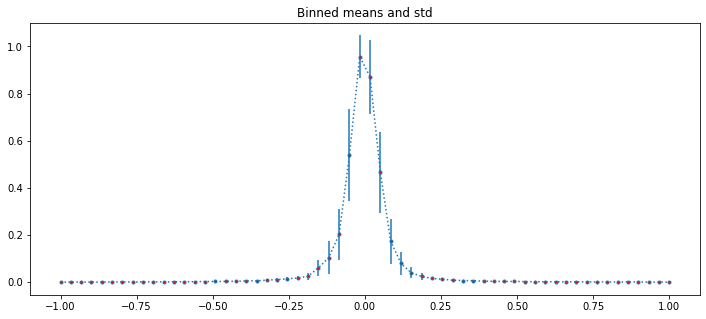

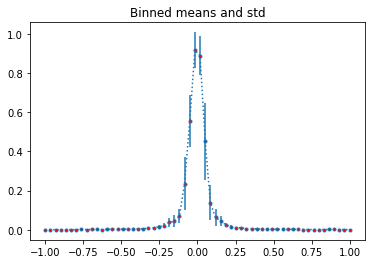

The total number of training datapoints is 1528 and validation points is 656


In [74]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

time = 10
energy = 200
nbins = 60
minval = -1
maxval = +1


x_train, y_train, x_val, y_val = prepare_mix_data(time, energy)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train[:,0], mean_vector_t, variance_vector_t]
print(count_t)


# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val[:,0], mean_vector_v, variance_vector_v]


### Apply smoothing to the signal
N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
smoothing_window_train = 100
smooth_y = np.array(smooth(df_train[:,1], 14))
smooth_y_test = np.array(smooth(df_val[:,1], 14))


# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
fig.set_size_inches(12, 5)
plt.show()

plot_uncertainties(x_val, y_val, nbins, minval, maxval)
fig.set_size_inches(12, 5)
plt.show()

print("The total number of training datapoints is", N_train, "and validation points is", N_test)


## Closure testing: 

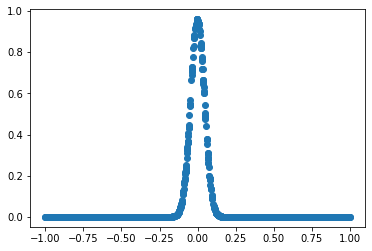

In [75]:
amp, cen, std = 0.96154166, -0.00242089, 0.04490686 #for t=10ms
#amp, cen, std = 9.23107789, -0.02310188, -0.39239466 
#amp, cen, std = 0.17912820, -0.00244745, 0.27709945 #for t=2ms

y_gaus = gaussian(df_train[:,0], amp, cen, std )

plt.plot(df_train[:,0], y_gaus, 'o')

## Neural Network 

### Create architecture

In [85]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.3)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

In [97]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])

predictions = make_model(x,1)

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 2e-2
seednumber = 24
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

train_x = add_time(df_train, 10)
train_sigma = df_train[:,2].reshape(N_train,1)
test_x = add_time(df_val, 10)
test_sigma = df_val[:,2].reshape(N_test,1)

chi_array = []


i = 0
Nrep = 50

while i < Nrep:

    train_y = copy(df_train[:,1]).reshape(N_train,1)  ## train_y = y_gaus in case of smoothing
    train_y += np.random.normal(0, train_sigma) # Create one replica of the training set
   # train_y += np.random.normal(0, train_sigma)
    
    #print("Shape of this round of Monte Carlo replicas is:", train_y.shape)

    test_y = copy(df_val[:,1]).reshape(N_test,1)
    test_y +=  np.random.normal(0, test_sigma) # Create Monte Carlo points
    test_y +=  np.random.normal(0, test_sigma)


    #print("Example of one training x, shape (,2):", train_x[80,:])
    #print("Example of one training y, shape (,1):", train_y[80])

    # Scaling input features to help the minimizer.
    train_scaler = StandardScaler()
    train_scaler.fit(train_x[:,0].reshape(1,-1))
    test_scaler = StandardScaler()
    test_scaler.fit(test_x[:,0].reshape(1,-1))

    ### Train and validate

    training_epochs = 50000
    max_rising_epochs = 20000 #The amount of epochs the minimzer is allowed to overfit before it stops
    display_step = 5000
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    predict_xx = np.linspace(-1.5, 1.5, N_train)
    predict_x = np.c_[predict_xx, 0*predict_xx+1]

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break


            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            })
    sess.close()

    # save to csv file
    from datetime import datetime
    predictions_values = predictions_values.reshape(N_train,)

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    
    chi_array.append(d[-1])

    now = datetime.now()
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seednumber}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
    np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seednumber}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')
    print(i)
    i+=1

Start training on 1528 and validating on 0656 samples
Epoch: 0001 | Training cost= 907128.437500000 | Validation cost= 938174.625000000
Epoch: 5001 | Training cost= 3.749177694 | Validation cost= 7.043635845
Epoch: 10001 | Training cost= 5.023565292 | Validation cost= 7.697215557
Epoch: 15001 | Training cost= 3.249420643 | Validation cost= 6.125256062
Epoch: 20001 | Training cost= 3.125339031 | Validation cost= 5.961596966
Epoch: 25001 | Training cost= 13.344253540 | Validation cost= 23.484474182
Epoch: 30001 | Training cost= 1.999145031 | Validation cost= 4.004223824
Epoch: 35001 | Training cost= 1.290519238 | Validation cost= 2.717612982
Epoch: 40001 | Training cost= 1.154533863 | Validation cost= 2.424345493
Epoch: 45001 | Training cost= 1.147359967 | Validation cost= 2.396544218
Optimization Finished!
0
Start training on 1528 and validating on 0656 samples
Epoch: 0001 | Training cost= 249573.062500000 | Validation cost= 200284.906250000
Epoch: 5001 | Training cost= 4.246413231 | Va

Epoch: 5001 | Training cost= 4.289577484 | Validation cost= 7.587905407
Epoch: 10001 | Training cost= 3.490837812 | Validation cost= 6.663803577
Epoch: 15001 | Training cost= 3.254163265 | Validation cost= 6.344551563
Epoch: 20001 | Training cost= 3.109965801 | Validation cost= 6.108219624
Epoch: 25001 | Training cost= 1.343244910 | Validation cost= 2.482822418
Epoch: 30001 | Training cost= 1.213017464 | Validation cost= 2.284631491
Epoch: 35001 | Training cost= 1.155207396 | Validation cost= 2.210413218
Epoch: 40001 | Training cost= 1.100117922 | Validation cost= 2.164385796
Epoch: 45001 | Training cost= 1.098319292 | Validation cost= 2.165498495
Optimization Finished!
10
Start training on 1528 and validating on 0656 samples
Epoch: 0001 | Training cost= 169408.984375000 | Validation cost= 109886.585937500
Epoch: 5001 | Training cost= 3.935775757 | Validation cost= 6.986003399
Epoch: 10001 | Training cost= 3.855919600 | Validation cost= 6.899323463
Epoch: 15001 | Training cost= 3.67916

Epoch: 10001 | Training cost= 3.801506758 | Validation cost= 6.556740284
Epoch: 15001 | Training cost= 3.284012318 | Validation cost= 6.246582031
Epoch: 20001 | Training cost= 2.911064148 | Validation cost= 5.668038845
Epoch: 25001 | Training cost= 1.658395052 | Validation cost= 3.209574699
Epoch: 30001 | Training cost= 1.236130953 | Validation cost= 2.355496883
Epoch: 35001 | Training cost= 2.187791824 | Validation cost= 4.902537823
Epoch: 40001 | Training cost= 1.119535804 | Validation cost= 2.175572872
Epoch: 45001 | Training cost= 1.110615015 | Validation cost= 2.174011707
Optimization Finished!
20
Start training on 1528 and validating on 0656 samples
Epoch: 0001 | Training cost= 159099.406250000 | Validation cost= 124065.781250000
Epoch: 5001 | Training cost= 4.303299904 | Validation cost= 7.652328968
Epoch: 10001 | Training cost= 3.684728861 | Validation cost= 6.957291603
Epoch: 15001 | Training cost= 3.315500736 | Validation cost= 6.484239578
Epoch: 20001 | Training cost= 3.1832

Epoch: 15001 | Training cost= 3.246985912 | Validation cost= 5.771889210
Epoch: 20001 | Training cost= 3.103847742 | Validation cost= 5.465859890
Epoch: 25001 | Training cost= 2.412412882 | Validation cost= 4.350977421
Epoch: 30001 | Training cost= 1.398838043 | Validation cost= 2.437199593
Epoch: 35001 | Training cost= 1.169216275 | Validation cost= 2.080962181
Epoch: 40001 | Training cost= 1.142483234 | Validation cost= 2.056808472
Epoch: 45001 | Training cost= 1.144465566 | Validation cost= 2.028801441
Optimization Finished!
30
Start training on 1528 and validating on 0656 samples
Epoch: 0001 | Training cost= 126060.757812500 | Validation cost= 84986.023437500
Epoch: 5001 | Training cost= 16.249408722 | Validation cost= 12.965259552
Epoch: 10001 | Training cost= 3.723476171 | Validation cost= 6.074579716
Epoch: 15001 | Training cost= 3.431331873 | Validation cost= 5.810808659
Epoch: 20001 | Training cost= 4.057977200 | Validation cost= 6.130661964
Epoch: 25001 | Training cost= 4.572

Epoch: 20001 | Training cost= 3.086403370 | Validation cost= 6.041125774
Epoch: 25001 | Training cost= 2.867954016 | Validation cost= 5.654246330
Epoch: 30001 | Training cost= 1.809987664 | Validation cost= 3.760130644
Epoch: 35001 | Training cost= 1.153987646 | Validation cost= 2.453502417
Epoch: 40001 | Training cost= 1.105641484 | Validation cost= 2.386672974
Epoch: 45001 | Training cost= 1.172624230 | Validation cost= 2.593434572
Optimization Finished!
40
Start training on 1528 and validating on 0656 samples
Epoch: 0001 | Training cost= 62420.386718750 | Validation cost= 36678.878906250
Epoch: 5001 | Training cost= 3.388355732 | Validation cost= 6.141945362
Epoch: 10001 | Training cost= 3.198255062 | Validation cost= 5.963771820
Epoch: 15001 | Training cost= 3.173209429 | Validation cost= 5.890659809
Epoch: 20001 | Training cost= 3.108196259 | Validation cost= 5.800054550
Epoch: 25001 | Training cost= 3.026945353 | Validation cost= 5.670943260
Epoch: 30001 | Training cost= 2.953726

### Plot outputs

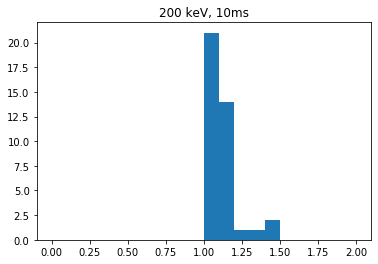

In [119]:
best_value = (min(chi_array))
best_try = np.where(chi_array == best_value)
np.savetxt('Data/Results/Chi2_200keV_10ms_Nrep=50', chi_array, delimiter=',', fmt='%f')
plt.hist(chi_array, bins=20, range=[0, 2])
plt.title('200 keV, 10ms')
plt.savefig('Figures/Chi2_200keV_10ms_Nrep=50')
plt.show()


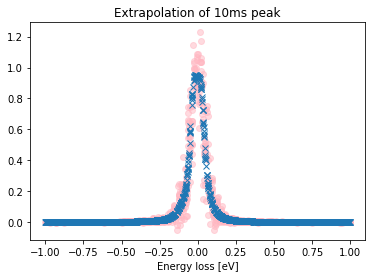

1528


In [120]:
plt.plot(df_train[:,0], train_y, 'o', alpha=.5, color='lightpink', label='One set of MC data points')
plt.plot(df_train[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
#plt.legend()
plt.xlabel(r'Energy loss [eV]')

plt.title('Extrapolation of 10ms peak')
plt.savefig('Figures/Extrapolation')
plt.show()

print(len(df_train))

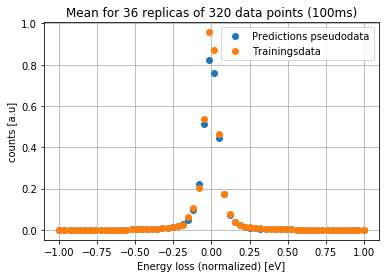

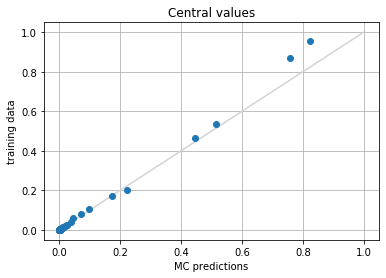

In [121]:
%run Evaluate_pseudodata.ipynb

#plt.plot(train_x, train_y,'o')
#plt.plot(pseudo_x, pseudo_pred, 'x', color='lightblue', label='Predictions')
plt.title('Mean for 36 replicas of 320 data points (100ms)')
pseudo_meanvector = np.linspace(-1,1,60)
plt.plot(pseudo_meanvector, pseudo10_mean, 'o', label = 'Predictions pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 60), mean_t, 'o', label='Trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(pseudo10_mean, mean_t, 'o')
plt.title('Central values')
plt.show()

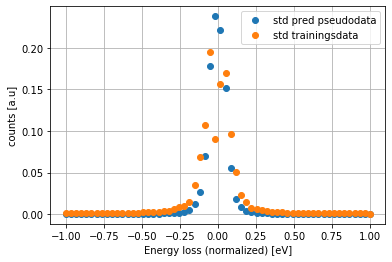

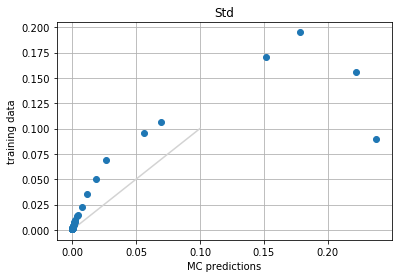

In [122]:
plt.plot(pseudo_meanvector, pseudo10_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 60), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,0.1,10), np.linspace(0,0.1,10), color='lightgrey')
plt.plot(pseudo10_std, std_t, 'o')
plt.title('Std')
plt.show()

## Residuals

In [123]:
best_res = residuals(best_pred, best_y, df_train[:,2])

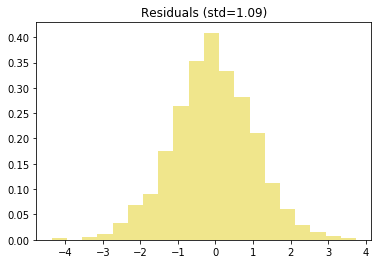

In [145]:
n, bins = np.histogram(best_res, bins=20)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

plt.hist(best_res, bins=20, density=True, color='khaki')
plt.title('Residuals (std=1.09)')
plt.savefig('Figures/Residuals_200keV_10ms')
plt.show()